## Import and input

In [15]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import Normalizer
import numpy as np
from matplotlib import pyplot as plt

df1 = pd.read_csv('./datasets/BATADAL_dataset03.csv')
df2 = pd.read_csv('./datasets/BATADAL_dataset04.csv')
df2.columns = df2.columns.str.replace(' ', '')
# all timestamps for attacks
attack_timestamps = list(df2.loc[df2['ATT_FLAG']==1].index)

# remove attack flag + datetime
df1 = df1.loc[:,df1.columns!='ATT_FLAG']
series = df1.loc[:,df1.columns!='DATETIME']
df2 = df2.loc[:,df2.columns!='ATT_FLAG']
series2 = df2.loc[:,df2.columns!='DATETIME']

# Function for pca anomaly detection


In [16]:
def pca_residuals(series,series2):
    # PCA requires normalized data
    normalizer = Normalizer()
    normalized_series =pd.DataFrame(normalizer.fit_transform(series))

    normalizer2 = Normalizer()
    normalized_series2 = pd.DataFrame(normalizer2.fit_transform(series2))

    # use PCA and find the importance of each principal component
    pca = PCA()
    pca.fit(normalized_series)
    print(pca.explained_variance_ratio_)
    
    # use most significant components to capture data behavior
    pca2 = PCA(n_components=7)
    pca2.fit(normalized_series)
    
    # project both the normal and anomalous data in the 7D Principal Component space
    projection = pca2.transform(normalized_series)
    projection2 = pca2.transform(normalized_series2)
    
    # use the 7 principal components to project the data back to the original space
    components = pca2.components_
    recreation = np.matmul(projection,components)
    recreation2 =  np.matmul(projection2,components)
    
    # calculate the residual per signal 
    residuals = np.subtract(np.array(normalized_series),recreation)
    residuals2 = np.subtract(np.array(normalized_series2),recreation2)
    
    # combine the residuals of all signals for each point in time
    residual = np.sum(np.square(residuals),axis=1)
    residual2 = np.sum(np.square(residuals2),axis=1)
    
    return residual, residual2


# Perform PCA analysis

[4.28863462e-01 2.87477511e-01 9.63679745e-02 7.96212084e-02
 6.50087149e-02 3.54596191e-02 2.69541784e-03 1.23769430e-03
 1.11080294e-03 7.53193281e-04 4.68901833e-04 2.21064511e-04
 1.68447095e-04 1.49070256e-04 1.01652721e-04 8.06353915e-05
 5.01064951e-05 3.74327705e-05 3.61903514e-05 3.36276395e-05
 2.97222321e-05 2.14115469e-05 3.09021143e-06 2.66227377e-06
 1.70766358e-07 1.05264995e-07 4.63193274e-08 2.60536800e-08
 1.36960710e-08 1.23302614e-08 1.15851628e-08 3.97080641e-10
 7.44504154e-11 8.02464438e-12 1.34848883e-12 1.05819241e-12
 3.01733015e-16 2.66697555e-33 2.66697555e-33 2.66697555e-33
 2.66697555e-33 2.66697555e-33 2.66697555e-33]


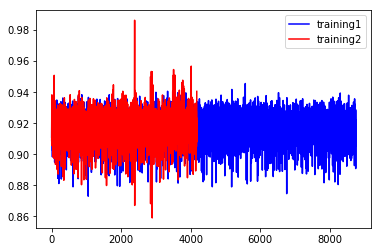

In [20]:
residual, residual2 = pca_residuals(series,series2)

# plot the residuals for both datasets and compare them
plt.plot(residual,'b')
plt.plot(residual2,'r')
plt.legend(['training1','training2'])
plt.savefig('pca_analysis')
plt.show()


## Evaluate PCA results

In [28]:
# set the conditions for anomalous behavior
threshold1 = np.max(residual)
threshold2 = np.min(residual)
detected_indices = np.where((residual2>threshold1))
print(detected_indices)
detected_rows = detected_indices[0]
unique_rows = set(detected_rows)
        
detected_indices = np.where((residual2<threshold2))
detected_rows = detected_indices[0]
for time_point in detected_rows:
    unique_rows.add(time_point)
unique_rows = list(unique_rows)
unique_rows.sort()

# compute conservative True Positives and False Positives
TP = 0
FP = 0
for j in unique_rows:
    if j in attack_timestamps:
        TP +=1
    else:
        FP +=1                
    
print(len(attack_timestamps))    
print(TP)
print(FP)

(array([  73, 2384, 2387, 2388, 2389, 2846, 2868, 2870, 2893, 3504, 3505,
       3509, 3510, 3552, 3754, 3771, 3772, 4017]),)
219
12
10
